In [21]:
###
## Analysis
#### Do advantages of ev's (better mileage and less emissions) effect their population among other vehicles 

import psycopg2
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [22]:
# Connect to the emissions database
conn1 = psycopg2.connect( host="database-2.c5go4e6kame4.us-east-1.rds.amazonaws.com",
                         database="postgres", user="postgres", password="javamylife", port="5432")
cursor1 = conn1.cursor()

In [23]:
q1 = """
BEGIN;
DROP FOREIGN TABLE public.counties, public.electric_vehicles , public.vehicle_primary_uses;
IMPORT FOREIGN SCHEMA public FROM SERVER foreign_server INTO public;
COMMIT;

SELECT *
FROM 
    (SELECT *
     FROM car_details
     INNER JOIN emission_standard ON car_details.stnd = emission_standard.stnd) AS details
INNER JOIN 
    (SELECT *
     FROM electric_vehicles
     INNER JOIN counties ON electric_vehicles.county_id = counties.id) AS population
ON details.cert_region = population.state
"""

In [24]:
df = pd.read_sql(q1, conn1)

conn1.close()

/var/folders/6g/4zq1d985075_7_l6gxj2n81m0000gn/T/ipykernel_39411/2840569235.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(q1, conn1)


In [25]:
df = df.loc[:, ~df.columns.duplicated()]
df = df.drop_duplicates()
df = df.drop(columns=['underhood_id', 'stnd_description'])

In [26]:
df

,stnd,model,disp,cyl,trans,drive,fuel,veh_class,air_pollution_score,city_mpg,...,county_id,vehicle_primary_use_id,bev,phev,ev_total,non_ev_total,total_vehicles,percent_ev,name,state
0,L3ULEV125,ACURA MDX,3.0,6.0,AMS-7,4WD,Gasoline,small SUV,3.0,26.0,...,613,5,1,1,2,188,190,1.05,Kern,CA
1,L3ULEV125,ACURA MDX,3.0,6.0,AMS-7,4WD,Gasoline,small SUV,3.0,26.0,...,549,5,1,0,1,167,168,0.60,Solano,CA
2,L3ULEV125,ACURA MDX,3.0,6.0,AMS-7,4WD,Gasoline,small SUV,3.0,26.0,...,465,5,1,0,1,28,29,3.45,Santa Cruz,CA
3,L3ULEV125,ACURA MDX,3.0,6.0,AMS-7,4WD,Gasoline,small SUV,3.0,26.0,...,489,5,4,3,7,1218,1225,0.57,Los Angeles,CA
4,L3ULEV125,ACURA MDX,3.0,6.0,AMS-7,4WD,Gasoline,small SUV,3.0,26.0,...,465,5,1,0,1,43,44,2.27,Santa Cruz,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3303715,L3LEV160,RAM 1500 TRX,6.2,8.0,Auto-8,4WD,Gasoline,pickup,1.0,10.0,...,609,5,1,0,1,58,59,1.69,San Mateo,CA
3303716,L3LEV160,RAM 1500 TRX,6.2,8.0,Auto-8,4WD,Gasoline,pickup,1.0,10.0,...,664,5,2,1,3,316,319,0.94,San Bernardino,CA
3303717,L3LEV160,RAM 1500 TRX,6.2,8.0,Auto-8,4WD,Gasoline,pickup,1.0,10.0,...,644,5,0,1,1,137,138,0.72,San Francisco,CA
3303718,L3LEV160,RAM 1500 TRX,6.2,8.0,Auto-8,4WD,Gasoline,pickup,1.0,10.0,...,465,5,1,0,1,19,20,5.00,Santa Cruz,CA


In [27]:
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] < '2021-01-01']

In [28]:
veh_specs = df.groupby('fuel')[['comb_co2', 'comb_co2_alternate', 'hwy_mpg', 'cmb_mpg', 'cmb_mpg_alternate', 'city_mpg']].mean().reset_index()
veh_specs.iloc[3, 4] = veh_specs.iloc[3, 5]

veh_specs = veh_specs.drop(columns=['cmb_mpg_alternate', 'comb_co2_alternate'])

In [29]:
veh_specs

,fuel,comb_co2,hwy_mpg,cmb_mpg,city_mpg
0,Diesel,425.406250,28.437500,24.312500,21.843750
1,Ethanol/Gas,458.088235,16.823529,14.176471,12.558824
2,Gasoline,397.400000,28.053151,24.143014,21.780822
3,Gasoline/Electricity,169.695652,30.149068,71.950311,28.590062


In [30]:
veh_population = df.groupby(df['date'].dt.year)[['ev_total', 'non_ev_total']].sum().reset_index()

In [31]:
veh_population

,date,ev_total,non_ev_total
0,2017,835164,187628724
1,2018,1165536,181995984
2,2019,1731888,191484432
3,2020,2080728,187507656


/var/folders/6g/4zq1d985075_7_l6gxj2n81m0000gn/T/ipykernel_39411/3565381767.py:4: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(hue = veh_specs['fuel'], y = veh_specs['comb_co2'], palette=palette, ax = axes[0,0])
/var/folders/6g/4zq1d985075_7_l6gxj2n81m0000gn/T/ipykernel_39411/3565381767.py:7: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(hue = veh_specs['fuel'], y = veh_specs['hwy_mpg'], palette=palette, ax = axes[0,1])
/var/folders/6g/4zq1d985075_7_l6gxj2n81m0000gn/T/ipykernel_39411/3565381767.py:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(hue = veh_specs['fuel'], y = veh_specs['city_mpg'], palette=palette, ax = axes[1, 0] )
/var/folders/6g/4zq1d985075_7_l6gxj2n81m0000gn/T/ipykernel_39411/3565381767.py:13: UserWarning: The palette list has more values (8) than needed (4), which may not be intend

Text(0, 0.5, 'Combined Mileage')

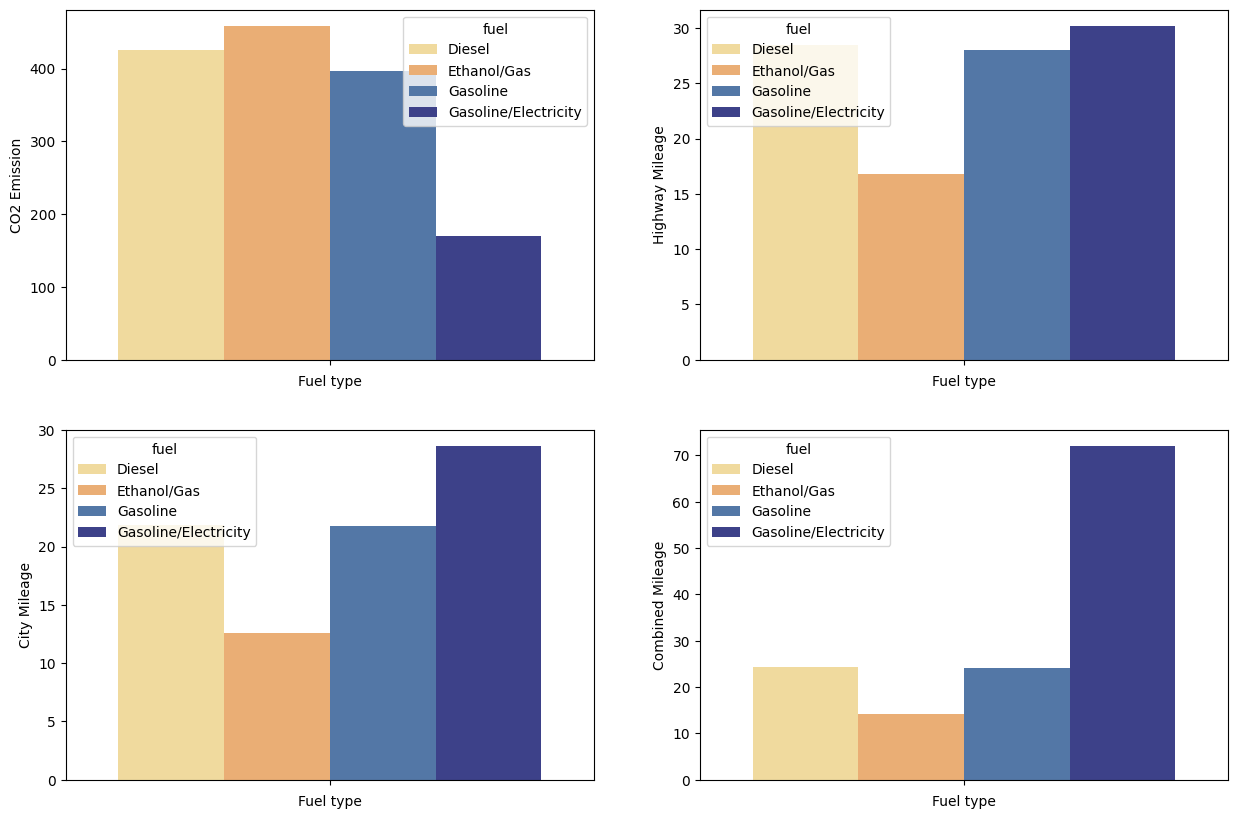

In [32]:
palette = ["#fee090", "#fdae61", "#4575b4", "#313695", "#e0f3f8", "#abd9e9", "#d73027", "#a50026"]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.barplot(hue = veh_specs['fuel'], y = veh_specs['comb_co2'], palette=palette, ax = axes[0,0])
axes[0, 0].set_xlabel("Fuel type")
axes[0, 0].set_ylabel('CO2 Emission')
sns.barplot(hue = veh_specs['fuel'], y = veh_specs['hwy_mpg'], palette=palette, ax = axes[0,1])
axes[0, 1].set_xlabel("Fuel type")
axes[0, 1].set_ylabel('Highway Mileage')
sns.barplot(hue = veh_specs['fuel'], y = veh_specs['city_mpg'], palette=palette, ax = axes[1, 0] )
axes[1, 0].set_xlabel("Fuel type")
axes[1, 0].set_ylabel('City Mileage')
sns.barplot(hue = veh_specs['fuel'], y = veh_specs['cmb_mpg'], palette=palette, ax = axes[1,1] )
axes[1, 1].set_xlabel("Fuel type")
axes[1, 1].set_ylabel('Combined Mileage')


Text(0.5, 1.0, 'EV population')

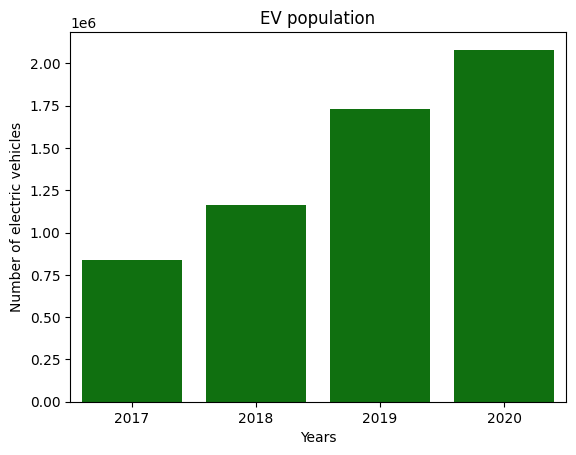

In [33]:
ax = sns.barplot(data=veh_population, x="date",y='ev_total', color='green')
ax.set_ylabel("Number of electric vehicles")
ax.set_xlabel("Years")
ax.set_title("EV population")